In [224]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.animation import FuncAnimation
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score

from IPython.display import clear_output

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# Data Exploration and Preprocessing

In [23]:
# Variables
file_path = 'airflow/dags/assets/matches-checkpoint.csv'
spanish_squads = ['Sevilla', 'Sporting Huelva', 'Athletic Club', 'Levante Planas',
                  'UDG Tenerife', 'Villarreal', 'Madrid CFF', 'Barcelona',
                  'Atlético Madrid', 'Real Madrid', 'Alhama', 'Alavés',
                  'Real Sociedad', 'Levante', 'Real Betis', 'Valencia']
useless_columns= [ 'Home_id', 'Away_id', 'Match_id', 'League_id']

In [163]:
# Load the data
matches = pd.read_csv(file_path)
matches = matches.drop(columns=useless_columns)

# Drop the rows in which the home or away team is not a spanish team
matches = matches[matches['Home'].isin(spanish_squads) | matches['Away'].isin(spanish_squads)]

display(matches.describe(), matches.sample(3), matches.info(), matches.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 0 to 86
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Wk         87 non-null     int64  
 1   Day        87 non-null     object 
 2   Date       87 non-null     object 
 3   Time       87 non-null     object 
 4   Home       87 non-null     object 
 5   xGHome     87 non-null     float64
 6   Score      87 non-null     object 
 7   xGAway     87 non-null     float64
 8   Away       87 non-null     object 
 9   xPHome     87 non-null     float64
 10  xPAway     87 non-null     float64
 11  ScoreHome  87 non-null     int64  
 12  ScoreAway  87 non-null     int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 9.5+ KB


,Wk,xGHome,xGAway,xPHome,xPAway,ScoreHome,ScoreAway
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,6.034483,1.406897,1.266667,1.448046,1.333103,1.643678,1.643678
std,3.182248,1.018639,0.921786,0.856089,0.841370,1.670378,1.613728
min,1.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000
25%,3.000000,0.600000,0.550000,0.760000,0.620000,1.000000,0.000000
50%,6.000000,1.200000,1.200000,1.280000,1.420000,1.000000,1.000000
75%,9.000000,1.900000,1.700000,2.195000,2.040000,2.000000,2.000000
max,11.000000,5.300000,5.300000,2.980000,2.980000,8.000000,7.000000


,Wk,Day,Date,Time,Home,xGHome,Score,xGAway,Away,xPHome,xPAway,ScoreHome,ScoreAway
15,4,Sat,2022-10-01,12:00,Alavés,1.7,0–4,2.4,Villarreal,1.01,1.79,0,4
27,5,Sun,2022-10-16,12:00,Real Madrid,3.0,7–1,0.3,Alavés,2.79,0.13,7,1
8,3,Sat,2022-09-24,12:00,Madrid CFF,3.4,3–1,0.5,Levante Planas,2.78,0.15,3,1


None

(87, 13)

In [164]:
# Perform EDA and preprocessing and handle data type conversions.
matches['Time'] = matches['Time'].apply(lambda a: datetime.strptime(a, '%H:%M').time()) # Convert to timedelta
matches['Date'] = pd.to_datetime(matches['Date']) # Convert to datetime


In [169]:
# Get the count of missing values in each column
display(matches.isnull().sum())
"""# Plot the missing values in columns with missing values as a histogram
plt.figure(figsize=(15, 5))

plt.title('Count of missing values in columns')
plt.xlabel('Columns')
plt.ylabel('Missing values')
plt.xticks(rotation=90)
plt.ylim(0,5)

sns.barplot(x=matches.columns, y=matches.isnull().sum(), fill=None, linewidth=1)

plt.show()"""

Wk           0
Day          0
Date         0
Time         0
Home         0
xGHome       0
Score        0
xGAway       0
Away         0
xPHome       0
xPAway       0
ScoreHome    0
ScoreAway    0
dtype: int64

"# Plot the missing values in columns with missing values as a histogram\nplt.figure(figsize=(15, 5))\n\nplt.title('Count of missing values in columns')\nplt.xlabel('Columns')\nplt.ylabel('Missing values')\nplt.xticks(rotation=90)\nplt.ylim(0,5)\n\nsns.barplot(x=matches.columns, y=matches.isnull().sum(), fill=None, linewidth=1)\n\nplt.show()"

,Wk,Day,Date,Time,Home,xGHome,Score,xGAway,Away,xPHome,xPAway,ScoreHome,ScoreAway
20,4,Sun,2022-10-02,12:00:00,Levante,0.9,2–1,1.3,Atlético Madrid,1.06,1.65,2,1
9,3,Sat,2022-09-24,12:00:00,Sporting Huelva,0.5,1–0,0.8,Alhama,1.03,1.57,1,0
74,10,Sat,2022-11-26,18:15:00,Real Madrid,3.1,5–1,0.7,Alhama,2.64,0.26,5,1
77,10,Sun,2022-11-27,14:00:00,Real Sociedad,3.5,3–0,0.5,Levante Planas,2.79,0.14,3,0


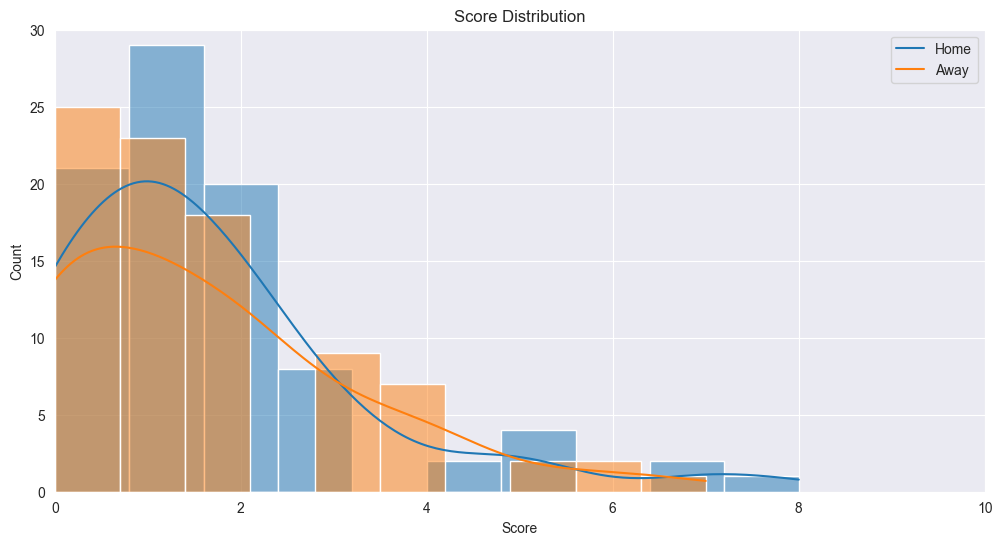

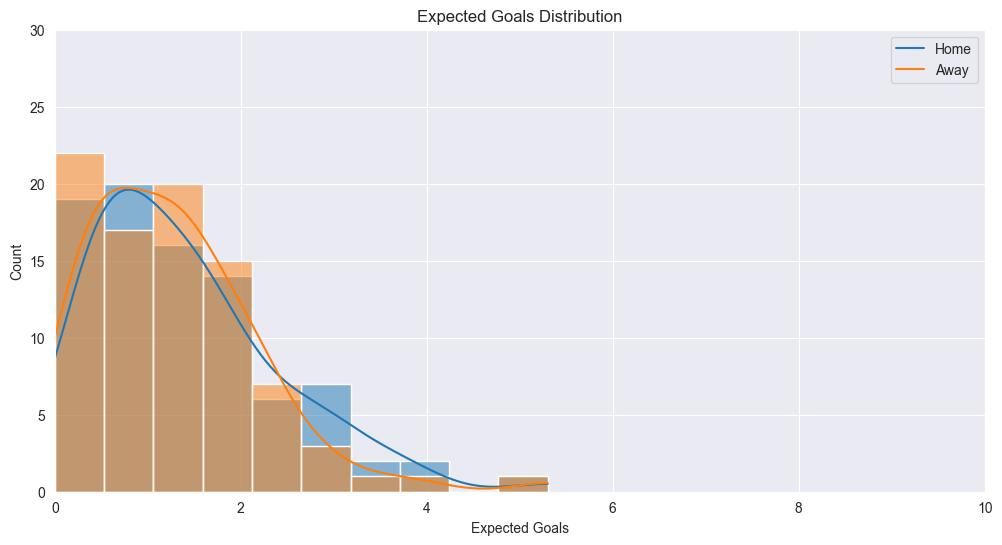

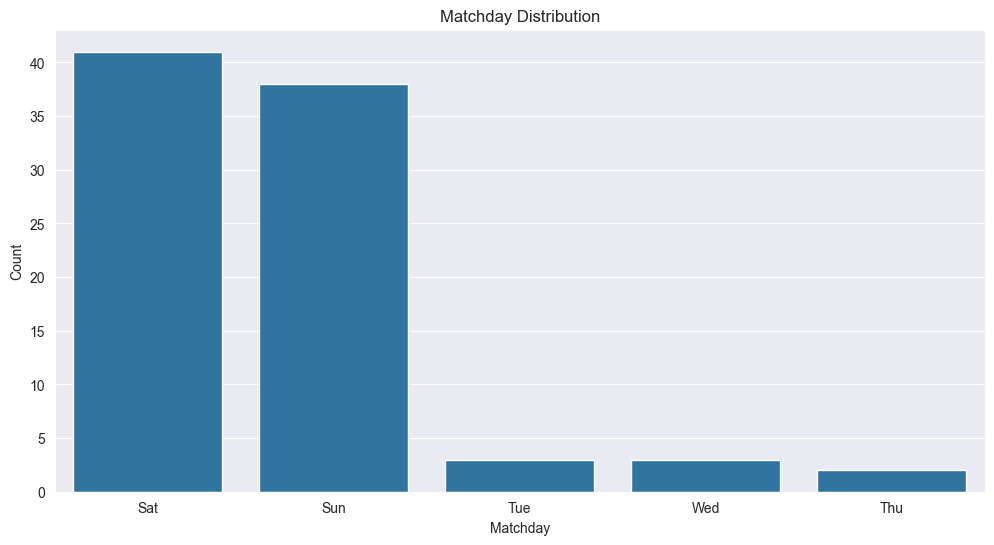

In [171]:
# Explore the statistical properties of the data, structure, features, etc.
display(matches.sample(4))

# Histogram of scores in seaborn
plt.figure(figsize=(12,6))
sns.histplot(matches['ScoreHome'], kde=True, stat='count', bins=10)
sns.histplot(matches['ScoreAway'], kde=True, stat='count', bins=10)

plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend(['Home', 'Away'])
plt.xlim(0, 10)
plt.ylim(0, 30)

plt.show() 

# Histogram of Expected Goals in seaborn
plt.figure(figsize=(12,6))
sns.histplot(matches['xGHome'], kde=True, stat='count', bins=10)
sns.histplot(matches['xGAway'], kde=True, stat='count', bins=10)

plt.title('Expected Goals Distribution')
plt.xlabel('Expected Goals')
plt.ylabel('Count')
plt.legend(['Home', 'Away'])
plt.xlim(0, 10)
plt.ylim(0, 30)

plt.show() # Expected goals are more normally distributed than actual goals

# Barplot of Match days in seaborn
plt.figure(figsize=(12,6))
sns.barplot(x=matches['Day'].value_counts().index, y=matches['Day'].value_counts().values)

plt.title('Matchday Distribution')
plt.xlabel('Matchday')
plt.ylabel('Count')

plt.show()

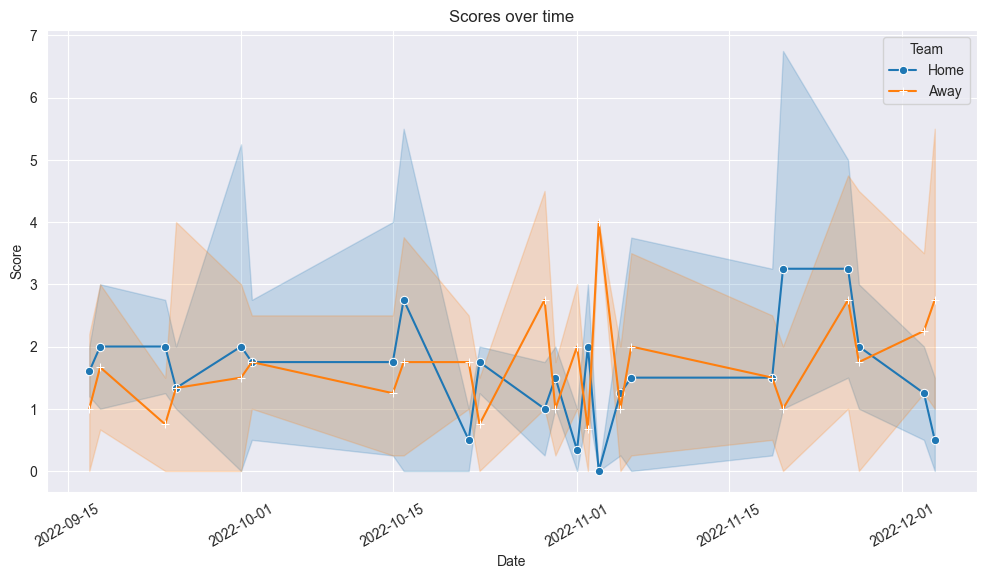

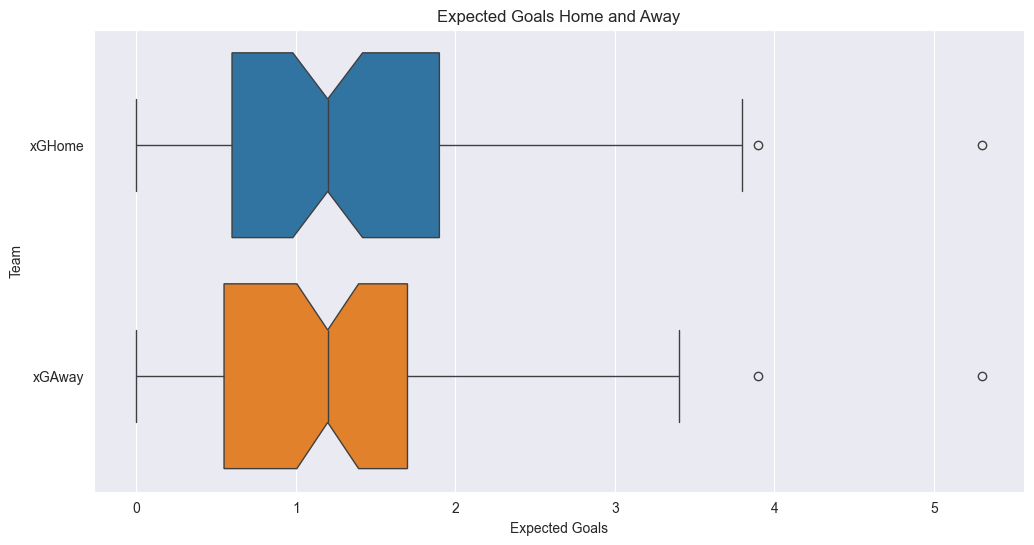

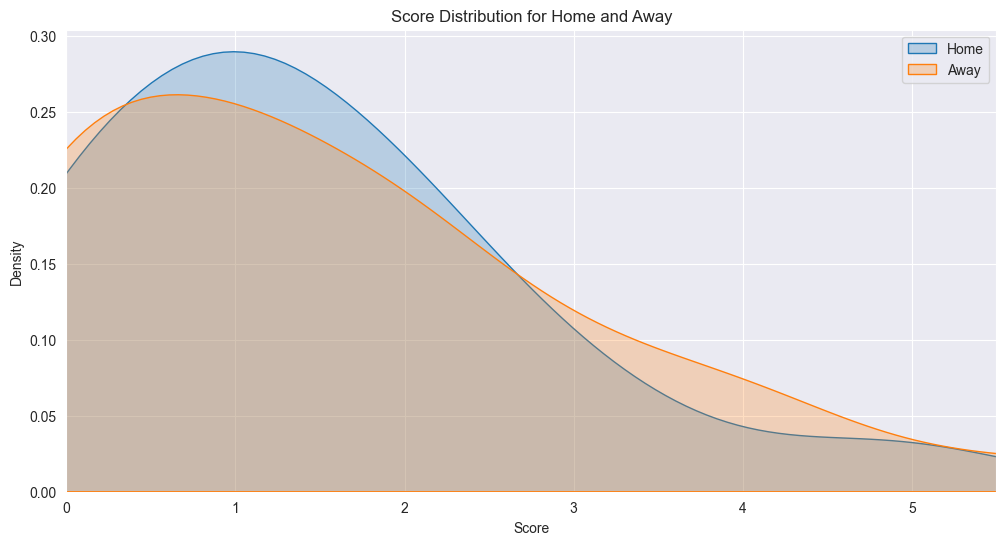

In [172]:
# LinePlot of Scores over time in seaborn
plt.figure(figsize=(12,6))

sns.lineplot(markers=True, marker='o', x='Date', y='ScoreHome', data=matches, label='Home')
sns.lineplot(markers=True, marker='+', x='Date', y='ScoreAway', data=matches, label='Away')

plt.xticks(rotation=30)
plt.title('Scores over time')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend(title='Team')

plt.show()

# Boxplot of Expected Goals Home and Away wo show the distribution of the data
plt.figure(figsize=(12,6))

sns.boxplot(data=matches[['xGHome', 'xGAway']], notch=True, orient='h')

plt.title('Expected Goals Home and Away')
plt.xlabel('Expected Goals')
plt.ylabel('Team')

plt.show()
# ------------------------------------------------- Same as above but with the kdeplot
plt.figure(figsize=(12,6))

sns.kdeplot(x=matches['ScoreHome'], shade=True)
sns.kdeplot(x=matches['ScoreAway'], shade=True)

plt.title('Score Distribution for Home and Away')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend(['Home', 'Away'])
plt.xlim(0, 5.5)

plt.show()

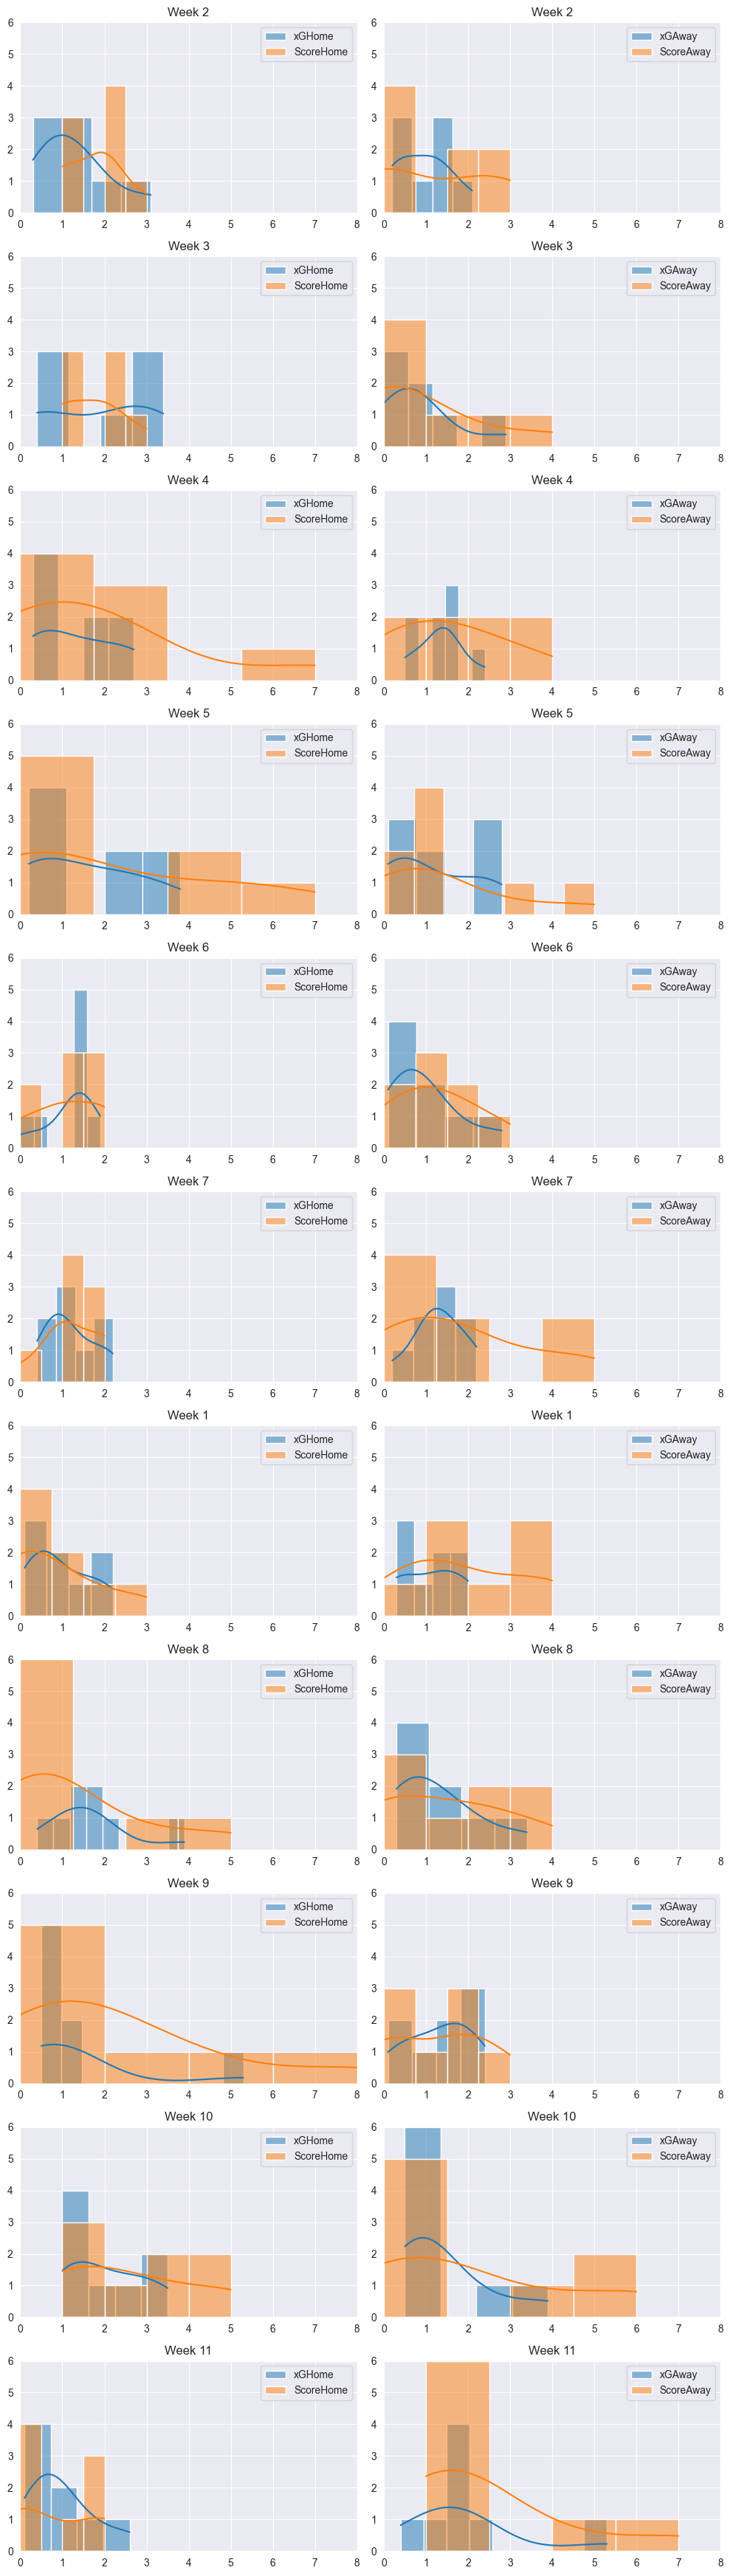

In [175]:
# Does the distribution of scores change as the weeks go by?
plt.figure(figsize=(10, 35))

integer_columns = ['xGHome', 'ScoreHome', 'xGAway', 'ScoreAway']
weeks = matches['Wk'].unique()
num_weeks = len(weeks)
num_cols = len(integer_columns) // 2

for i, week in enumerate(weeks):
    plt.subplot(num_weeks, num_cols, i*num_cols+1)
    plt.ylim(0, 6)
    plt.xlim(0, 8)
    for col in integer_columns[:2]:
        sns.histplot(matches[matches['Wk'] == week][col], stat='count', kde=True, label=col)
    plt.title(f'Week {week}')
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

    plt.subplot(num_weeks, num_cols, i*num_cols+2)
    plt.ylim(0, 6)
    plt.xlim(0, 8)
    for col in integer_columns[2:]:
        sns.histplot(matches[matches['Wk'] == week][col], stat='count', kde=True, label=col)
    plt.title(f'Week {week}')
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

plt.tight_layout()
plt.show()

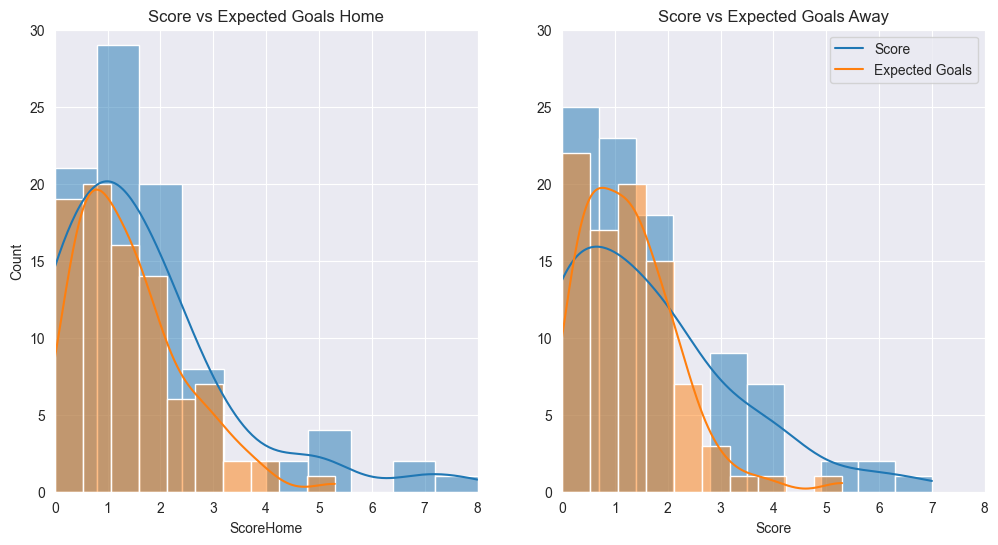

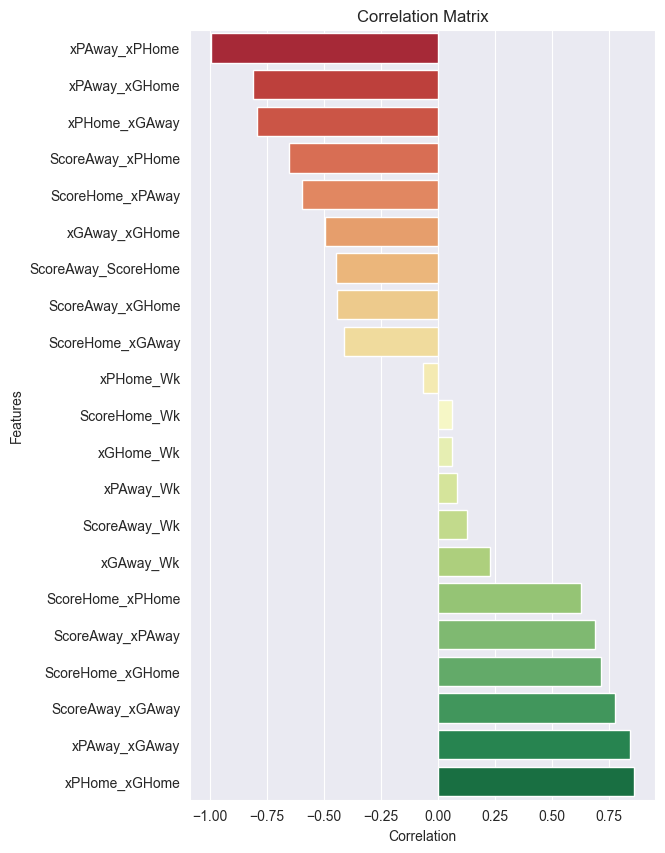

In [183]:
# Is there a correlation between the expected goals and the actual goals?
plt.figure(figsize=(12,6))

for i, col in enumerate(['Home', 'Away']):
    plt.subplot(1, 2, i+1)

    plt.xlim(0, 8)
    plt.ylim(0, 30)
    
    sns.histplot(x=f'Score{col}', data=matches,  kde=True, stat='count', bins=10)
    sns.histplot(x=f'xG{col}', data=matches,  kde=True, stat='count', bins=10)
    
    plt.title(f'Score vs Expected Goals {col}')

plt.xlabel('Score')
plt.ylabel('')
plt.legend(['Score', 'Expected Goals'])

plt.show() 

# Plot the correlation matrix
numeric_columns = matches.select_dtypes(include=np.number).columns
correlations = matches[numeric_columns].corr()
columns = correlations.columns
rows = correlations.index

corresponding = []
correlations_list = []

for col in columns:
    for row in rows:
        corresponding.append(row+'_'+col)

correlations = correlations.values.flatten()

for idx, value in enumerate(corresponding):
    correlations_list.append([value, correlations[idx]])   

processed_labels = set()
labels = []
values = []

for label, value in sorted(correlations_list, key=lambda x: x[1]):
    reverse_label = '_'.join(label.split('_')[::-1])
    
    if label not in processed_labels and reverse_label not in processed_labels and label != reverse_label:
        labels.append(label)
        values.append(value)
        processed_labels.add(label)

sorted_labels, sorted_values = zip(*sorted(zip(labels, values), key=lambda x: x[1]))


plt.figure(figsize=(6,10))

norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
sns.barplot(y=sorted_labels, x=sorted_values, palette=sns.color_palette('RdYlGn', len(sorted_labels)), order=sorted_labels)

plt.xlabel('Correlation')
plt.ylabel('Features')
plt.title('Correlation Matrix')

plt.show()

# Feature Engineering

In [194]:
# Create interaction terms: Multiplication of 2 features which have a joint effect on the target variable to create a new feature that captures this effect.
interaction_terms = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_var   = interaction_terms.fit_transform(matches[['xGHome', 'xGAway']])

# Encode Categorical Features
categorical_columns = matches.select_dtypes(include='object').columns #['Day', 'Time', 'Home', 'Score', 'Away']
useful_categorical  = categorical_columns.drop('Score')

matches['Numeric_Day'] = matches['Day'].apply(lambda x: 2 if x == 'Tue' else 3 if x == 'Wed' else 4 if x == 'Thu' else 6 if x == 'Sat' else 7) # Encode the Day column
display(matches['Time'].value_counts()) # I was going to ignore the Time column

encoder = LabelEncoder()
matches['Numeric_Home'] = encoder.fit_transform(matches['Home'])
matches['Numeric_Away'] = encoder.transform(matches['Away']) # Use the same encoder as the Home column"""

encoder_time = OrdinalEncoder()
matches['Numeric_Time'] = encoder_time.fit_transform(matches['Time'].values.reshape(-1, 1)) # Ignore the first column to avoid the dummy variable trap

matches_encoded = matches.select_dtypes(include=np.number)

display(matches_encoded.sample(3))

Time
12:00:00    32
16:00:00    19
18:00:00     9
18:15:00     7
19:00:00     4
11:00:00     4
17:00:00     2
20:00:00     2
21:00:00     2
14:00:00     2
17:45:00     1
11:45:00     1
18:45:00     1
16:30:00     1
Name: count, dtype: int64

,Wk,xGHome,xGAway,xPHome,xPAway,ScoreHome,ScoreAway,Numeric_Day,Numeric_Home,Numeric_Away,Numeric_Time
22,4,0.5,1.5,0.62,2.12,0,3,7,2,9,8.0
33,6,1.3,1.7,1.11,1.65,0,2,6,12,10,4.0
3,2,1.6,0.8,1.94,0.80,2,0,6,9,14,4.0


# Model Building

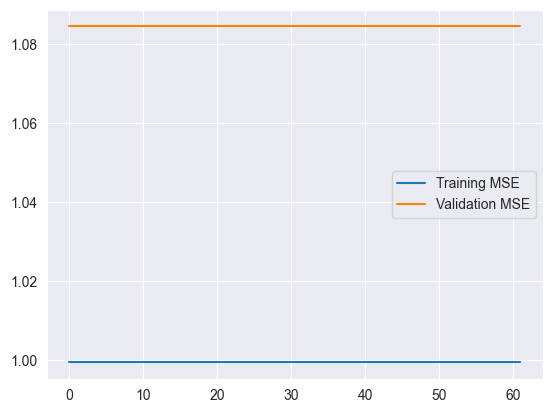

In [226]:
display(matches_encoded.sample(3))
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(matches_encoded.drop(columns=['ScoreHome', 'ScoreAway']), matches_encoded[['ScoreHome', 'ScoreAway']], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize lists to store training and validation accuracy
training_mse = []
test_mse = []
validation_mse = []
n_iterations = 100

lr_model = LinearRegression()

for epoch in range(n_iterations):
    clear_output(wait=True)
    lr_model.fit(X_train, y_train)

    y_train_pred = lr_model.predict(X_train)
    curr_train_score = mean_squared_error(y_train, y_train_pred) # Calculate the current training score

    y_val_pred = lr_model.predict(X_val)
    curr_val_score = mean_squared_error(y_val, y_val_pred) # Calculate the current validation score

    training_mse.append(curr_train_score) # Store the current training scores
    validation_mse.append(curr_val_score) # Store the current validation scores

    plt.plot(training_mse, label='Training MSE')
    plt.plot(validation_mse, label='Validation MSE')
    plt.legend()
    plt.show()

# Airflow and SQLite